# Pierre VAMBENEPE (02-01-2021)
# TPQ : Final project


**Asymmetric Information Detection in options**

Abstract :
My goal is to use this output to detect events of asymmetrical information in stock options market.

Asymmetrical information can stem from criminal behaviours like insider trading but also from an edge given by advanced research to actors deploying extensive means like the use of mobile phone data, private polls or other types of intelligence gathering along with machine learning treatment of those data.
The development of those techniques risks undermining the business model of less specialized actors, including market makers, thus jeopardizing the structure of the market.

Asymmetrical information can be detected in retrospect because they will ultimately lead to a dramatic shift of a parameter such as the spot price, the volatility or the dividend yield.

The goal here is to identify signals in the trading pattern that will alert liquidity providers that something is fishy.


In [2]:
#First some global setting :

#This program has been developed on Pycharm Professional for windows 10
#The Python exec is installed as a specific miniconda env running Python 3.6 with the following extensions

# Note on Pycharm : it was for me necessary to install the following kernel on conda in order to let Jyputer Notebook execute :
# conda activate myenv
# python -m ipykernel install --user --name myenv --display-name "Python (myenv)
# cf https://youtrack.jetbrains.com/issue/PY-36913

#before running the script, you should crerate the following folders :
# './processed'
# './parameters'
# './XY'
# './MLoutput'
# and copy the following provided files in the "./parameters" folder :
# UDL_DAI.pkl
# Execs_DAI.pkl
# UDL_SX5E.pkl
# Execs_SX5E.pkl


import numpy as np
import pandas as pd
import os
import datetime
import math
import scipy.stats as si
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

folder1 = './processed'
folder2 = './parameters'
folder3 = './XY'
folder4 = './MLoutput'

ref = 'SX5E'
indexlist = ['SX5E']
stocks_list = ['SX5E', 'DAI']

In [3]:
#This part is to take into account bank holidays in the computation of business days

bank_h = ['01-01-2020','10-04-2020','13-04-2020','01-05-2020','01-06-2020','24-12-2020','25-12-2020','31-12-2020',
'01-01-2019','19-04-2019','22-04-2019','01-05-2019','24-12-2019','25-12-2019','26-12-2019','31-12-2019',
'01-01-2018','02-04-2018','01-05-2018','21-05-2018','03-10-2018','24-12-2018','25-12-2018','26-12-2018',
'31-12-2018','14-04-2017','17-04-2017','01-05-2017','05-06-2017','03-10-2017','31-10-2017','25-12-2017',
'26-12-2017']
bank_h_ts = np.array([np.datetime64(pd.Timestamp(elt).date()) for elt in bank_h])

def time_between(a, b):
   nbd = np.busday_count(a.date(), b.date(), holidays=bank_h_ts)
   TimeA = datetime.datetime.combine(datetime.date.today(), a.time())
   TimeB = datetime.datetime.combine(datetime.date.today(), b.time())
   if TimeB > TimeA:
    addhours = (TimeB - TimeA).total_seconds() / 3600
   else:
    addhours = -((TimeA - TimeB).total_seconds() / 3600)
   return (nbd + addhours/8.5)/252


def get_last_working(dt):
    while dt in bank_h_ts:
        dt = dt - datetime.timedelta(1)
    return(dt)

In [4]:
#This part is here to allow a selection of chosen expiration dates (in this case monthly expi)
#fist we take every friday then filter out all none 3rd thirdays

opening_hours_str = "07:00"
closing_hours_str = "15:30"
time_fmt = "%H:%M"
opening_hours = datetime.datetime.strptime(opening_hours_str, time_fmt).time()
closing_hours = datetime.datetime.strptime(closing_hours_str, time_fmt).time()

from_date = '2019-01-01'
until_date = '2019-12-31'
last_matu = '2022-12-31'
dates = list(pd.date_range(from_date, until_date, freq='D').strftime('%Y-%m-%d'))
dates_expi = list(pd.date_range(from_date, last_matu, freq='W'))
dates_expi = [elt - datetime.timedelta(2) for elt in dates_expi]
dates_expi = [datetime.datetime.combine(elt, closing_hours) for elt in dates_expi if elt.day in [15, 16, 17, 18, 19, 20, 21]]
dates_expi = [get_last_working(elt) for elt in dates_expi]
dates_expi_trim = [elt for elt in dates_expi if elt.month in [3, 6, 9, 12]]


**This class allows us to graph the results of our processing along the way**
It is not important and can be overlooked.
It is only used in between tasks to give a sense of what we have achieved.

In [5]:
class Graph():
    def __init__(self, udl = 'DAI'):
        self.udl = udl
        try:
            if udl != '':
                self.dfp = pd.read_pickle(folder2 + '/Parameters_' + udl + '.pkl')
                self.dfi = pd.read_pickle(folder2 + '/Inputs_' + udl + '.pkl')
                self.dfx = pd.read_pickle(folder3 + '/X_' + udl + '.pkl')
                self.dfxtd = pd.read_pickle(folder3 + '/Xtd_' + udl + '.pkl')

                self.dfxy = pd.read_pickle(folder3 + '/XY_' + udl + '.pkl')
            else:
                self.dfxy = pd.read_pickle(folder3 + '/XY_all_stocks -st 2-lt 20.pkl')
        except:
            pass

    def graph_params(self, year = 2020, month = 9):
        expi1 = pd.Timestamp(str(year) + "-{:02d}".format(month) + "-15 15:30:00")
        listexpi= [expi1 + pd.Timedelta(i, unit='d') for i in range(7)]
        self.dfpt = self.dfp.loc[self.dfp.ExpiDate.isin(listexpi)]
        mask = (self.dfpt['StartTime'].dt.year == year)
        self.dfpt = self.dfpt[mask]

        self.dfpt['divyield'] = (1 - self.dfpt['FwdRatio']) * 100
        self.dfpt['EWMA_divyield'] = (1 - self.dfpt['EWMA_FwdRatio']) * 100
        self.dfpt['MSE (bps)'] = self.dfpt['Error']
        self.dfpt.index = self.dfpt.StartTime

        plt.close()
        self.dfpt[['EWMA_ATF', 'EWMA_SMI', 'EWMA_CVX', 'EWMA_divyield', 'MSE (bps)']].plot(secondary_y=['EWMA_ATF', 'EWMA_CVX'], title ="Parameters for " + self.udl + " " + str(month) + "/" + str(year) + " maturity")
        plt.show()


    all_month = [i+1 for i in range(12)]
    def graph_inputs(self, year = 2020, expi_month=all_month, graph_month=all_month, field = 'EWMA_ATF'):
        self.l = list(dict.fromkeys(self.dfi.MaturityDate.tolist()))

        plt.close()
        for expi in [elt for elt in self.l if (elt.year == year) and (elt.month in expi_month)]:
            self.dfit = self.dfi.loc[self.dfi.MaturityDate == expi]

            mask1 = self.dfit.index.year == year
            self.dfit = self.dfit[mask1]

            self.dfit['month'] = self.dfit.index.month
            mask2 = self.dfit.month.isin(graph_month)
            self.dfit = self.dfit[mask2]

            ax = self.dfit[field].plot(title=self.udl + " : " + field + " for all maturities of " + str(year), grid=True, label=expi, legend=True)
            ax.xaxis.set_major_locator(mdates.DayLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %d'))
        plt.show()


    def graph_inputs_rg(self, fields = ['EWMA_ATF', 'TotalSignedSensiATF']):
        plt.close()
        for rg in self.rg:
            self.dfit = self.dfi.loc[self.dfi.MaturityDate == rg[0][1]]

            lst_times = [elt[0] for elt in rg]
            lst_tim_ext5D = [elt for elt in self.dfit.index if
                             ((elt > lst_times[-1]) and (elt < lst_times[-1] + pd.Timedelta(7, unit='D')))]
            lst_tim_prev5D = [elt for elt in self.dfit.index if
                             ((elt < lst_times[0]) and (elt > lst_times[0] - pd.Timedelta(7, unit='D')))]
            lst_t = lst_tim_prev5D + lst_times + lst_tim_ext5D
            self.dfit = self.dfit.loc[lst_t, :]
            secondary = [elt for elt in fields if (('EWMA_ATF' in elt) or ('EWMA_CVX' in elt))]
            ax = self.dfit[fields].plot(title=self.udl + ", Matu : " + str(rg[0][1]), secondary_y=secondary, grid=True, legend=True)
            plt.axvline(x=lst_times[0], color='k', linestyle='--')
            plt.axvline(x=lst_times[-1], color='k', linestyle='--')
            ax.xaxis.set_major_locator(mdates.DayLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%y %m %d'))
            plt.show()


    def graph_X(self, year=2020, field='EWMA_ATF'):
        self.listcol = [elt for elt in self.dfx.columns if (elt[0] == field) and (elt[1].year == year)]
        self.dfxt = self.dfx[self.listcol]
        newlistcol = [elt[1] for elt in self.listcol]
        self.dfxt.columns = newlistcol
        plt.close()
        self.dfxt.plot()
        plt.show()


    def graph_XY(self, year=2019, month = 12, filtertype = 1, field='dt-EWMA_ATF', stage='xdt'):
        if stage=='xdt':
            df = self.dfxtd
            listdif1 = ['EWMA_ATF', 'EWMA_FwdRatio']
            if filtertype == 1:
                for cl in [elt + '-type' for elt in listdif1]:
                    df = df.loc[df[cl] != 0]
            elif filtertype == 2:
                for cl in [elt + '-type' for elt in listdif1]:
                    df = df.loc[df[cl] != 1]
        else:
            df = self.dfxy



        #for color, either nearby:
        if field[:3] == 'dt-':
            nearby = field[3:]+'-nearby'
        elif field[:2] == 'Y-':
            nearby = field[2:] + '-nearby'
        else:
            nearby = field + '-nearby'
        #or matu
        df['matur'] = [elt[1] for elt in df.index]



        self.listcol = [elt for elt in df.columns if elt in [field, nearby]] + ['matur']

        if year=='':
            self.dfxyt = df.loc[:, self.listcol]
            newlistindex = [elt[0] for elt in df.index]
            self.dfxyt.index = newlistindex
        else:
            self.listindex = [elt for elt in df.index if (elt[1].year == year) and (elt[1].month == month)]
            self.dfxyt = df.loc[self.listindex, self.listcol]
            newlistindex = [elt[0] for elt in self.listindex]
            self.dfxyt.index = newlistindex

        self.dfxyt['time'] = self.dfxyt.index
        # self.dfxyt_pt = pd.pivot_table(self.dfxyt, values = field, index = 'time',  columns = nearby, aggfunc = np.mean)
        self.dfxyt_pt = pd.pivot_table(self.dfxyt, values=field, index='time', columns='matur', aggfunc=np.mean)

        plt.close()
        self.dfxyt_pt.plot()
        plt.show()

    def color(self, v):
        if v==1:
            return('black')
        elif v==-1:
            return ('red')
        else:
            return('yellow')

    def graph_XY_scatter(self, x1, x2, y):
        self.dfxy.dropna(how='any', inplace=True)
        color = [self.color(elt) for elt in self.dfxy[y]]
        self.dfxy.plot.scatter(x=x1, y=x2, c=color, s=1)
        plt.show()
        print('average distance to center y=0 vs y=1 : ' + x1 + ', ' + x2 + ', ' + y)
        self.dfxy['d1'] = self.dfxy.apply(lambda x: abs(x[x1]), axis=1)
        self.dfxy['d2'] = self.dfxy.apply(lambda x: x[x2], axis=1)
        self.dfxy['dall'] = self.dfxy.apply(lambda x: (x[x1]**2 + x[x2]**2)**0.5, axis=1)
        R0 = self.dfxy.loc[self.dfxy[y] == 0][['d1', 'd2', 'dall']].mean()
        R1 = self.dfxy.loc[self.dfxy[y] == 1][['d1', 'd2', 'dall']].mean()
        print(R0)
        print(R1)

    def get_list_events(self, field = 'Y-EWMA_ATF', value=1):
        g.dfxy.index.names = ['Time', 'Matu']
        df = g.dfxy.copy()
        df = df.sort_index(level=['Matu', 'Time'], ascending=[True, True])
        self.rg = []
        inY = False
        for i in range(df.shape[0]):
            if not inY and (df[field][i] == value):
                inTime = i
                matu = df.index[i][1]
                inY = True
            if inY and ((df[field][i] != value) or (matu != df.index[i][1])):
                self.rg = self.rg + [df.index[inTime:i]]
                inY = False

**Inputs**

Deutsche Boerse shares intraday data of trades on single stock options, usable for free for non commercial purposes :
https://github.com/Deutsche-Boerse/dbg-pds.

I have used a Docker container in order to retrieve them from Amazon Cloud Services.
The next phase was to process them and save them into a pandas dataframe.
In order to focus on the essential, I'll skip this part here and provide the pickel of the dataframes of intraday trades for options and underlying for the Eurostoxx50 (SX5E) and Daimler (DAI)
I have also reduced the size of the data to 2019 in order to reduce execution time which should still be around 2 hours.
The 4 following files should be in the folder "./processed":
UDL_DAI.pkl
Execs_DAI.pkl
UDL_SX5E.pkl
Execs_SX5E.pkl
(UDL gives the underlying execs and exec gives the options execs)

**The next stage is to build a pricer for european and american options,
in order to calibrate the parameters of a vol surface each tiçme it is possible,
and to calculate sensitivity of a price to some parameters (delta, vega...)**

Each underlying and maturity are treated separately.

Every trade is priced only once along with options sensitivity on spot and volatility parameters.
The processed is seeded with the parameters obtained with the preceding cluster. First order extrapolation along Spot, ATF, SMI and CVX sensitivities is used thereafter for the calibration of the cluster.

The pricers used are a european Black and Scholes pricer with continuous dividend yield and a binomial tree for american options also with a continuous dividend yield for american options above a certain threshold of dividenyield (we use the european closed formula pricer under this threshold for speed purposes).
Even when using a binomial tree, the pricing of american options is not very precise due to the lack of data regarding the exact dividend ex-date. In order to prevent too big an impact from that, we filter out calls with a delta over X%.
This inexactitude is not to damaging are we will eventually be looking for big moves in parameters.

The volatility surface model is a simple 2nd degree polynomial equation on moneyness. Sigma(K, T) = ATF(T) - SMI(T) * moneyness + CVX(T) * moneyness²
with moneyness = ln(K/F)
K = Strike
F = Forward

In [6]:
class Pricing():
    def __init__(self):
        # self.indexlist = ['SX5E']
        time_fmt = "%H:%M"
        self.opening_hours = datetime.datetime.strptime(opening_hours_str, time_fmt).time()
        self.closing_hours = datetime.datetime.strptime(closing_hours_str, time_fmt).time()

        self.smile_sliding_coef = 1

    def euro_vanilla_pricer(self, S, K, T, r, repo, sigma, type):
        sigma = sigma / 100
        d1 = (np.log(S / K) + (r - repo + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - repo - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        if type == 'Call':
            return (S * np.exp(-repo * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
        else:
            return (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-repo * T) * si.norm.cdf(-d1, 0.0,
                                                                                                          1.0))

    def american_vanilla_pricer(self, S, K, r, repo, sigma, T, N=1000):
        sigma = sigma / 100
        # credit to http://gosmej1977.blogspot.com/2013/02/american-options.html
        # calculate delta T
        deltaT = float(T) / N

        # up and down factor will be constant for the tree so we calculate outside the loop
        u = np.exp(sigma * np.sqrt(deltaT))
        d = 1.0 / u

        # to work with vector we need to init the arrays using numpy
        fs = np.asarray([0.0 for i in range(N + 1)])

        # we need the stock tree for calculations of expiration values
        fs2 = np.asarray([(S * u ** j * d ** (N - j)) for j in range(N + 1)])

        # we vectorize the strikes as well so the expiration check will be faster
        fs3 = np.asarray([float(K) for i in range(N + 1)])

        # rates are fixed so the probability of up and down are fixed.
        # this is used to make sure the drift is the risk free rate
        a = np.exp((r - repo) * deltaT)
        p = (a - d) / (u - d)

        # Compute the leaves, f_{N, j}
        fs[:] = np.maximum(fs2 - fs3, 0.0)

        # calculate backward the option prices
        for i in range(N - 1, -1, -1):
            fs[:-1] = np.exp(-r * deltaT) * (p * fs[1:] + (1 - p) * fs[:-1])
            fs2[:] = fs2[:] * u

            # Simply check if the option is worth more alive or dead
            fs[:] = np.maximum(fs[:], fs2[:] - fs3[:])

        # print fs
        return fs[0]


    def vanilla_pricer(self, S, K, T, r, sigma, fwdRatio, type):
        indic = (1 - fwdRatio) / max(1 / 12, T) ** 0.5
        # not taking moneyness into account because all calls must have same method + only OTM calls anyway
        repo = - math.log(fwdRatio) / max(1 / 128, T)
        if (type == "Call") and (indic > 0.02) and (self.udl not in indexlist):
            return (self.american_vanilla_pricer(S, K, r, repo, sigma, T))
        else:
            return (self.euro_vanilla_pricer(S, K, T, r, repo, sigma, type))


    def get_vol_and_sensi(self, spot, RefSpot, strike, TTM, ATF, SMI, CVX, FwdRatio, sensi):
        # first pivot
        ATFnew = ATF - math.log(spot * FwdRatio / RefSpot) * SMI * self.smile_sliding_coef / (max(1.0 / 128, TTM)) ** 0.5
        # then get vol
        moneyness = math.log(strike / spot * FwdRatio)
        vol = ATFnew - moneyness * 10 * SMI / max(1.0 / 128, TTM) ** 0.5 + moneyness ** 2 * CVX / max(1.0 / 128, TTM)
        if sensi:
            delta = self.get_vol_and_sensi(spot * 1.01, RefSpot, strike, TTM, ATF, SMI, CVX, FwdRatio, False) - vol
            sensiATF = self.get_vol_and_sensi(spot, RefSpot, strike, TTM, ATF + 0.01, SMI, CVX, FwdRatio, False) - vol
            sensiSMI = self.get_vol_and_sensi(spot, RefSpot, strike, TTM, ATF, SMI + 0.01, CVX, FwdRatio, False) - vol
            sensiCVX = self.get_vol_and_sensi(spot, RefSpot, strike, TTM, ATF, SMI, CVX + 0.01, FwdRatio, False) - vol
            return (vol, delta, sensiATF, sensiSMI, sensiCVX)
        else:
            return vol

**The next step is to build a class in order to fit**

I decided to clusterize consecutive trades by groups containing at least 5 traded calls and 5 traded puts.

The idea here is to be able to first perform a calibration of the forward-to-spot ratio prior to the calibration of volatility parameters. This will prevent any miscalibration resulting from a sudden change of this ratio following either a dividend payment or a change in the dividend forecast.

For that, we will perform a WLS (weighted OLS) to determine which forward-to-spot ratio fits best the n trades in the cluster. The weights are used to balance the positive and negative delta (call and puts) in the cluster.

With one row per trade in the cluster so :

X =
[sensi_delta_opt1
sensi_delta_opt2
sensi_delta_opt3
...]

Y =
[Traded_price_opt1 - Model_price_opt1_with_param(t-1)
Traded_price_opt2 - Model_price_opt2_with_param(t-1)
Traded_price_opt3 - Model_price_opt3_with_param(t-1)
...]

the result of the regression gives the shift to be applied to the forward-to-spot ratio (cf code get_new_fwd_ratio in the Fitting class)

Once this is done, we want to see how to alter volatility parameters in order to best fit the traded prices of the cluster.
We will be starting by pricing the trades with the parameters of the previous cluster along with the associated sensitivities (sensi_vega, sensi_smile...).
We will then be using an Elastic Net Regression rather than OLS in order to give more rigidity to parameters with less variability like smile and convexity.
Each row corresponds to a trade in the cluster so :

X =
[sensi_vega_opt1 * std_vega, sensi_smile_opt1 * std smile, sensi_convex_opt1 * std_convex

sensi_vega_opt2 * std_vega, sensi_smile_opt2 * std smile, sensi_convex_opt2 * std_convex

sensi_vega_opt3 * std_vega, sensi_smile_opt3 * std smile, sensi_convex_opt3 * std_convex

...]

Y =
[Traded_price_opt1 - Model_price_opt1_with_param(t-1)

Traded_price_opt2 - Model_price_opt2_with_param(t-1)

Traded_price_opt3 - Model_price_opt3_with_param(t-1)

...]

We look for a vector alpha which minimizes: ||Y-X * alpha||2 + epsilon1*||alpha||1 + epsilon2*||alpha||2 (see elastic net regression) The result gives the move to apply to parameters :

ATF(t) = ATF(t-1) + alpha[0]*std_vega

SMI(t) = SMI(t-1) + alpha[1]*std_smile

CVX(t) = CVX(t-1) + alpha[2]*std_cvx

(see function "get_new_vols_params" in the Fitting class)

In [7]:
class Fitting(Pricing):

    def filter(self, x):
        try:
            st = x.split(' ')
            if self.udl in indexlist:
                return (st[5] in ['P', 'C'])
            else:
                return ((st[4] == 'AM') and (st[5] in ['P', 'C']))
        except:
            return True

    def __init__(self, inputfolder, udl, MaturityDate):
        super(Fitting, self).__init__()
        self.udl = udl
        self.df = pd.read_pickle(inputfolder + '/Execs_' + udl + '.pkl')

        # filter Maturity
        self.MaturityDate = MaturityDate
        self.df = self.df.loc[self.df.MaturityDate == MaturityDate]
        #filter single opt, american for single stock
        self.df['filterOpt'] = self.df.MLEG.apply(lambda x: self.filter(x))
        self.df = self.df.loc[self.df.filterOpt==True]
        # self.df['MaturityDate'] = self.df['MaturityDate'].apply(
        #     lambda x: datetime.datetime.combine(x.date(), self.closing_hours))
        if self.df.shape[0] < 50:
            self.bigEnough = False
        else:
            # we need a unique index so the timestamp cannot do
            self.df['timeOfTrade'] = self.df.index.tolist()
            self.df = self.df.reset_index(drop=True)

            for coef in ['RefSpot', 'ATF', 'SMI', 'CVX', 'FwdRatio', 'ModelPrice', 'ModelPrice2', 'ModelPrice3',
                         'sensiDelta', 'sensiATF', 'sensiSMI', 'sensiCVX', 'OTM', 'iv']:
                self.df[coef] = np.nan

            self.start_min_nb_opt_per_cluster = 5
            self.min_nb_opt_per_cluster = self.start_min_nb_opt_per_cluster

            self.ATF = 25
            self.SMI = 1.5
            self.CVX = 30
            self.TTM = 0
            self.FwdRatio = 1
            self.RefSpot = self.df.PriceU[0]

            self.stdParams = np.array([0.5, 0.1, 1.5])  # standard dev

            # filter out if error (meaning half spread between max and min over 1 minute) is too large in retrieved data
            # print(self.df.shape)
            # print('filter out if error is too large')
            self.df = self.df.loc[self.df.ErrorU < 15]  # 15bps for stocks
            self.df = self.df.loc[self.df.ErrorO < 5]  # 5bps for options
            # print(self.df.shape)

            self.start_index = self.df.index[0]

            # create dataframe with params
            self.df_params = pd.DataFrame(
                columns=['ExpiDate', 'StartIndex', 'StartTime', 'Interval', 'RefSpot', 'ATF', 'SMI', 'CVX', 'FwdRatio',
                         'TTM', 'Error'])
            self.bigEnough = True

    def clusterize(self):
        nb_calls = 0
        nb_puts = 0
        self.cluster = pd.DataFrame()

        iter = self.df.loc[self.start_index:].iterrows()
        for pos, row in iter:
            if row.PutOrCall == 'Call':
                nb_calls += 1
            else:
                nb_puts += 1

            if (nb_calls >= self.min_nb_opt_per_cluster) and (nb_puts >= self.min_nb_opt_per_cluster):
                # print(pos)
                self.last_index = pos
                try:
                    self.end_index, value = next(iter)
                except:
                    self.end_index = pos + 1
                self.cluster = self.df.loc[self.start_index:self.end_index].copy()
                break


    def reref(self):
        newrefspot = self.cluster.PriceU.mean() * self.FwdRatio
        newTTM = self.cluster.TTM.mean()

        self.ATF = self.ATF - math.log(newrefspot / self.RefSpot) * self.SMI * self.smile_sliding_coef / (
            max(1.0 / 128, newTTM)) ** 0.5

        self.RefSpot = newrefspot
        self.TTM = newTTM
        self.cluster['RefSpot'] = self.RefSpot

    def price_cluster(self, udl):
        for pos, row in self.cluster.iterrows():
            vol, delta, sensiATF, sensiSMI, sensiCVX = self.get_vol_and_sensi(row.PriceU, self.RefSpot, row.StrikePrice,
                                                                              row.TTM, self.ATF, self.SMI, self.CVX,
                                                                              self.FwdRatio, True)
            ModelPrice = self.vanilla_pricer(row.PriceU, row.StrikePrice, row.TTM, 0, vol, self.FwdRatio, row.PutOrCall)
            sensidelta = self.vanilla_pricer(row.PriceU * 1.01, row.StrikePrice, row.TTM, 0, vol + delta, self.FwdRatio,
                                             row.PutOrCall) - ModelPrice
            sensivega = self.vanilla_pricer(row.PriceU, row.StrikePrice, row.TTM, 0, vol + 1, self.FwdRatio,
                                            row.PutOrCall) - ModelPrice

            self.cluster.loc[pos, 'ModelPrice'] = ModelPrice
            self.cluster.loc[pos, 'sensiDelta'] = sensidelta
            self.cluster.loc[pos, 'sensiATF'] = sensivega * sensiATF
            self.cluster.loc[pos, 'sensiSMI'] = sensivega * sensiSMI
            self.cluster.loc[pos, 'sensiCVX'] = sensivega * sensiCVX
            self.cluster.loc[pos, 'iv'] = vol

            if udl not in indexlist:
                delta_range = [0.5, 0.05, -0.6, -0.05]
                # adjust if we get close to a div
                indic = (1 - self.FwdRatio) / max(1 / 12, row.TTM) ** 0.5
                if indic > 0.02:
                    delta_range = [0.45, 0.05, -0.6, -0.05]
                if indic > 0.06:
                    delta_range = [0.4, 0.05, -0.6, -0.05]
                if indic > 0.1:
                    delta_range = [0.35, 0.05, -0.6, -0.05]
            else:
                delta_range = [0.5, 0.05, -0.5, -0.05]

            dtpct = sensidelta / row.PriceU * 100
            if ((row.PutOrCall == 'Call') and (dtpct < delta_range[0]) and (dtpct > delta_range[1])) or (
                    (row.PutOrCall == 'Put') and (dtpct > delta_range[2]) and (dtpct < delta_range[3])):
                self.cluster.loc[pos, 'OTM'] = True
            else:
                self.cluster.loc[pos, 'OTM'] = False

    def get_new_fwd_ratio(self):

        # filter out ITM options
        # print('filter out ITM options')
        # print(self.cluster.shape)
        self.cluster = self.cluster.loc[self.cluster.OTM == True]
        # self.cluster.loc[self.cluster.OTM == True].shape

        # normalize qty to give same weight to calls and puts
        dfcalls = self.cluster.loc[self.cluster.PutOrCall == 'Call']
        deltacalls = (dfcalls.NumberOfContracts ** 0.5 * dfcalls.sensiDelta).sum()
        checkSizeCalls = (
                    dfcalls.sensiDelta / dfcalls.PriceU * 100).sum()  # sum of all indivual delta (in %) should be at least 30%
        dfputs = self.cluster.loc[self.cluster.PutOrCall == 'Put']
        deltaputs = (dfputs.NumberOfContracts ** 0.5 * dfputs.sensiDelta).sum()
        checkSizePuts = (
                    dfputs.sensiDelta / dfputs.PriceU * 100).sum()  # sum of all indivual delta (in %) should be at least 30%

        # handle rare cases were all calls (resp puts) are ITM
        if (checkSizeCalls < .3) or (checkSizePuts > -.3):
            return False
        else:
            self.cluster['W'] = np.nan
            self.cluster.loc[self.cluster.PutOrCall == 'Call', 'W'] = \
                self.cluster.loc[self.cluster.PutOrCall == 'Call'].NumberOfContracts ** 0.5 / deltacalls
            self.cluster.loc[self.cluster.PutOrCall == 'Put', 'W'] = \
                self.cluster.loc[self.cluster.PutOrCall == 'Put'].NumberOfContracts ** 0.5 / -deltaputs

            # find best FwdRatio adjustment with WLS
            X = np.float64(np.array(self.cluster.sensiDelta))
            Y = np.float64(np.array(self.cluster.PriceO - self.cluster.ModelPrice))
            W = np.float64(np.array(self.cluster.W))

            wls_model = sm.WLS(Y, X, weights=W)
            # wls_model = sm.WLS(Y, X)
            self.results = wls_model.fit()
            newFwdRatio = self.FwdRatio * (1 + self.results.params[0] * 0.01)

            # readjust ModelPrices with this new FwdRatio
            self.cluster['ModelPrice2'] = self.cluster.ModelPrice + self.cluster.sensiDelta * (
                        newFwdRatio - self.FwdRatio) * 100
            self.FwdRatio = newFwdRatio
            self.cluster['FwdRatio'] = newFwdRatio

            # for elt in ['', '2']:
            #     print((((fit.cluster['ModelPrice' + elt] - fit.cluster.PriceO) / fit.cluster.PriceU * 10000) ** 2).mean() ** 0.5)  # in bps

            return True


    def get_new_vols_params(self):
        # NB : if a cluster mixes pre and post dividend trades, it will be messy. I expect that the error cap
        # mechanism will sort out those cases
        # find best FwdRatio adjustment with WLS
        X = np.float64(np.array(self.cluster[['sensiATF', 'sensiSMI', 'sensiCVX']]) * self.stdParams) / self.RefSpot
        Y = np.float64(np.array(self.cluster.PriceO - self.cluster.ModelPrice2)) / self.RefSpot
        # W = np.float64(self.cluster.NumberOfContracts)
        # wls_model = sm.WLS(Y, X, weights=W)
        modelOLS = sm.OLS(Y, X)

        a = 10**(-12) * (10 - 9/52 * min(1/self.TTM, 52))
        #the closer to maturity, the more volatile are the parameters
        results = modelOLS.fit_regularized(method='elastic_net', alpha=a, L1_wt=0.5)

        self.ATF = self.ATF + results.params[0] * 0.01 * self.stdParams[0]
        self.SMI = self.SMI + results.params[1] * 0.01 * self.stdParams[1]
        self.CVX = self.CVX + results.params[2] * 0.01 * self.stdParams[2]

        self.cluster['ATF'] = self.ATF
        self.cluster['SMI'] = self.SMI
        self.cluster['CVX'] = self.CVX

        self.cluster['ModelPrice3'] = self.cluster.ModelPrice2 + np.array(
            results.params * self.cluster[['sensiATF', 'sensiSMI', 'sensiCVX']] * self.stdParams).sum(axis=1)


    def write_down(self):
        # copy back into df
        self.df.loc[self.cluster.index, :] = self.cluster

        # populate parameter dataframe
        start = self.df.loc[self.start_index, 'timeOfTrade']
        end = self.df.loc[self.last_index, 'timeOfTrade']
        interval = time_between(start, end)
        # hours = (end - start).seconds / 60 / 60
        # if hours > 9:
        #     interval = (end - start).days + 1 + (24 - hours) / 8.5 * 0.7
        # else:
        #     interval = (end - start).days + hours / 8.5 * 0.7

        # get mean error in bps
        self.error = (((self.cluster.ModelPrice3 - self.cluster.PriceO) ** 2).mean()) ** 0.5 / self.RefSpot * 1000

        self.df_params.loc[self.df_params.shape[0]] = [self.MaturityDate, self.start_index, start, interval,
                                                       self.RefSpot, self.ATF, self.SMI, self.CVX, self.FwdRatio,
                                                       self.TTM, self.error]
        # print(self.df_params.tail(2))

        self.start_index = self.end_index


    def compute_EWMA(self):
        Tau = 0.2/252  # halflife in years of time for ewma (ie. 0.2day)

        self.df_params['Interval'] = (self.df_params['Interval'] + self.df_params['Interval'].shift(
            1)) / 2  # the params are valid for the middle of the period so the time between 2 observation is the avergae of 2 consecutive intervals

        # halftime_td = datetime.timedelta(hours = tau)
        # for elt in ['ATF', 'SMI', 'CVX', 'FwdRatio']:
        #     self.df_params['EWMA_' + elt] = self.df_params['EWMA_' + elt].ewm(halflife=halftime_td, times=self.df_params['Interval']).mean())
        self.df_params['alpha'] = self.df_params.Interval.apply(lambda x: 1 - math.exp(- x / Tau))

        for pos in self.df_params.index.tolist():
            for elt in ['ATF', 'SMI', 'CVX', 'FwdRatio']:
                if pos == 0:
                    self.df_params.loc[pos, 'EWMA_' + elt] = self.df_params.loc[pos, elt]
                else:
                    self.df_params.loc[pos, 'EWMA_' + elt] = self.df_params.loc[pos, 'alpha'] * self.df_params.loc[pos, elt] \
                        + (1 - self.df_params.loc[pos, 'alpha']) * self.df_params.loc[pos - 1, 'EWMA_' + elt]

**We will now use the fitting class in order to get a dataframe of parameters for both DAI and SX5E**

In [8]:
P = Pricing()

for udl in stocks_list:
    print(udl)

    res = pd.DataFrame()

    for MaturityDate in dates_expi:
        print(MaturityDate)
        fit = Fitting(folder1, udl, MaturityDate)
        if fit.bigEnough:
            fit.clusterize()

            while (fit.cluster.shape[0] > 0) and (fit.df.loc[fit.last_index, 'timeOfTrade'] < MaturityDate - datetime.timedelta(5)):
                fit.reref()
                fit.price_cluster(udl)
                possible = fit.get_new_fwd_ratio()
                if possible:
                    oldATF = fit.ATF
                    oldSMI = fit.SMI
                    oldCVX = fit.CVX
                    fit.get_new_vols_params()
                    if (fit.min_nb_opt_per_cluster == fit.start_min_nb_opt_per_cluster) and \
                        ((abs(fit.ATF-oldATF)>fit.stdParams[0]*4) or (abs(fit.SMI-oldSMI)>fit.stdParams[1]*6) or (abs(fit.CVX-oldCVX)>fit.stdParams[2]*8)):
                        print('lets recompute the fwd ratio')
                        print(fit.ATF, oldATF, fit.SMI, oldSMI,fit.CVX, oldCVX)
                        fit.min_nb_opt_per_cluster += 1
                    else:
                        fit.write_down()
                        fit.min_nb_opt_per_cluster = fit.start_min_nb_opt_per_cluster
                else:
                    fit.min_nb_opt_per_cluster += 1

                fit.clusterize()

            fit.compute_EWMA() #halftime in hours
            if res.shape[0] == 0:
                res = fit.df_params.copy()
            else:
                res = res.append(fit.df_params, ignore_index=True)
            print(res.tail(2))

    # Filter out if Error is too big
    before = res.shape[0]
    compare_range = max(30, int(before/100/2))
    res.to_pickle(folder2 + '/Parameters_before_filter_' + udl + '.pkl')
    res = res.sort_values(by='StartTime', ascending=True)
    global_mean = res.Error.mean()
    res['maxE'] = res.Error.rolling(compare_range*2).mean().shift(periods=-compare_range, fill_value=0).apply(lambda x: max(global_mean, x)) * (2 + 3 * res.TTM.apply(lambda x: min(2, x)))
    res = res.loc[res.Error < res.maxE]
    print('Pct rows out ' + str(1 - res.shape[0] / before))
    #take out TTM column
    del res['TTM']

    res.to_pickle(folder2 + '/Parameters_' + udl + '.pkl')

SX5E
2019-01-18 15:30:00
lets recompute the fwd ratio
20.089392732739938 25.011279578890097 1.554886364769402 1.5 28.967598177660097 30
              ExpiDate StartIndex           StartTime  Interval      RefSpot        ATF       SMI        CVX  FwdRatio       TTM     Error     alpha   EWMA_ATF  EWMA_SMI   EWMA_CVX  EWMA_FwdRatio
66 2019-01-18 15:30:00       1010 2019-01-11 14:45:00  0.000237  3059.290515  15.275486  1.408780  26.894986  1.003342  0.020116  0.081600  0.258455  15.417351  1.393715  26.888369       1.003248
67 2019-01-18 15:30:00       1021 2019-01-11 15:04:00  0.000113  3066.295277  15.155458  1.412664  26.874552  1.003632  0.019994  0.023276  0.132515  15.382646  1.396226  26.886538       1.003299
2019-02-15 15:30:00
lets recompute the fwd ratio
19.527112237066135 25.006706388521245 1.466631058985643 1.5 29.018053149205173 30
               ExpiDate StartIndex           StartTime  Interval      RefSpot        ATF       SMI        CVX  FwdRatio       TTM     Error     a

**The output of this code is pandas dataframes giving time series of the following calibrated parameters : ATF, SMI, CVX, divyield along with traded volumes. **

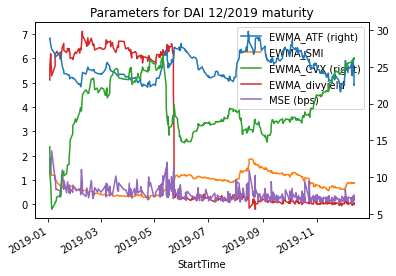

In [9]:
g = Graph('DAI')
g.graph_params(year=2019, month =12)

**Obtaining proper time series**

A set of parameters were thus generated for each batch of 5 trades for any given maturity.
This leads to a series that is unevenly sampled. Thanks to some extrapolation (1 day max) the BuildInputs class transform these data into a proper time series of parameters sampled on 1 minute intervals.
Separately, we also create neat, 1-minute sampled, time series deriving from the actual trades (the sames that we used to calibrate the vols parameters).

This series is then merged in the same dataframe as Pricing class in order to collect the associated sensitivity (vega, sega, div sensitivity). The idea here is to later associate a jump in traded volume on one parameter to a later surge in the associated parameter : This will happen if someone had the information leading to this surge before the rest of market participants and tried to take advantage of this knowledge.

Going further still, the sensitivities of the trades are "signed" in order to (try to) signify if it was a buying or selling interest.
The disputable hypothesis here is that if the parameter is going up, then it means that trades happening at this time are responsible for this trend (since trades are what is used to do the calibration) so these trades must be buying the sensitivity (vega or other).

Once merged into the df_pivot dataframe, those inputs will be used to compute the actual X and Y for our machine learning project.

In [10]:
class BuildInputs(Pricing):

    def __init__(self, udl, matu):
        super(BuildInputs, self).__init__()

        self.udl = udl
        self.matu = matu
        self.df_params = pd.read_pickle(folder2 + '/Parameters_' + udl + '.pkl')
        self.df_volume = pd.read_pickle(folder1 + '/Execs_' + udl + '.pkl')
        self.df_udl = pd.read_pickle(folder1 + '/UDL_' + udl + '.pkl')
        # self.list_matu = sorted(list(self.df_params['ExpiDate'].unique()))
        self.df_volume = self.df_volume.loc[self.df_volume.MaturityDate == matu]
        self.df_params = self.df_params.loc[self.df_params.ExpiDate == matu].iloc[3:,:]
        #  eliminate the 3 first parameters to give allow for convergence


    def find_middle(self, a, b): #in minutes of open market
        if (a==a) and (b==b):
            ti = self.timeline.index(b) - self.timeline.index(a)
            return self.timeline[self.timeline.index(a) + int(ti/2)]
        else:
            return np.nan


    def even_index(self):
        date_ranges = []
        start = self.df_volume.index.min()
        non_empty_days = sorted(list(self.df_udl.index.unique()))
        for date in list(dict.fromkeys([elt.date() for elt in non_empty_days if ((elt>=start) and (elt<=self.matu))])):
            t1 = datetime.datetime.combine(date, self.opening_hours)
            t2 = datetime.datetime.combine(date, self.closing_hours)
            date_ranges.append(pd.DataFrame({"OrganizedDateTime": pd.date_range(t1, t2, freq='1Min').values}))
        agg = pd.concat(date_ranges, axis=0)
        # agg.index = agg["OrganizedDateTime"].values

        # we center the index of df_params on the middle of the cluster
        self.timeline = agg["OrganizedDateTime"].tolist()
        self.df_params.index = [self.find_middle(a, b) for a, b in zip(self.df_params.StartTime, self.df_params.StartTime.shift(-1))]
        # self.df_params.index = self.df_params.index.map(lambda x: x.round('1min'))
        # self.df_params = self.df_params.iloc[1:, :]

        #we make sure that the index list of params is unique (not 2 calibration in the same minute)
        self.df_params = self.df_params.groupby(self.df_params.index).mean()

        #we reindex
        self.df_params = self.df_params.reindex(agg["OrganizedDateTime"].values)


        features = ['RefSpot', 'EWMA_ATF', 'EWMA_SMI', 'EWMA_CVX', 'EWMA_FwdRatio']
        for f in features:
            self.df_params[f] = self.df_params[f].interpolate(limit=60*8, limit_area='inside') #use 'time' option? + limit says that we won't extraoplate beyond 1 day


    def get_total_sensi(self):

        self.df_volume = pd.merge(self.df_volume, self.df_params, left_index=True, right_index=True, how='left')

        for f in ['EWMA_ATF', 'EWMA_SMI', 'EWMA_CVX', 'EWMA_FwdRatio']:
            self.df_volume[f + '_prec'] = self.df_volume[f].shift(1)

        for prec_or_not in ['', '_prec']:
            self.df_volume['vi'+prec_or_not], self.df_volume['delta'+prec_or_not], self.df_volume['sensiATF'+prec_or_not], self.df_volume['sensiSMI'+prec_or_not], self.df_volume['sensiCVX'+prec_or_not] = \
                self.df_volume.apply(lambda x: self.get_vol_and_sensi(x.PriceU, x.RefSpot, x.StrikePrice, x.TTM, x['EWMA_ATF'+prec_or_not],
                x['EWMA_SMI'+prec_or_not], x['EWMA_CVX'+prec_or_not], x['EWMA_FwdRatio'+prec_or_not], True), axis=1, result_type='expand')

            self.df_volume['Price'+prec_or_not] = self.df_volume.apply(lambda x: self.vanilla_pricer(x.PriceU, x.StrikePrice, x.TTM, 0,
                x['vi'+prec_or_not], x['EWMA_FwdRatio'+prec_or_not], x.PutOrCall), axis=1)


        self.df_volume['TotalSensiATF'] = self.df_volume.apply(
            lambda x: (self.vanilla_pricer(x.PriceU, x.StrikePrice, x.TTM, 0, x.vi + x.sensiATF, x.EWMA_FwdRatio,
                                          x.PutOrCall) - x.Price) / max(1/52, x.TTM)**0.5 * x.NumberOfContracts, axis=1)
        #it is actually weighted vega annualized
        self.df_volume['TotalSensiSMI'] = self.df_volume.apply(
            lambda x: (self.vanilla_pricer(x.PriceU, x.StrikePrice, x.TTM, 0, x.vi + x.sensiSMI, x.EWMA_FwdRatio,
                                          x.PutOrCall) - x.Price) * x.NumberOfContracts, axis=1)
        self.df_volume['TotalSensiFwdRatio'] = self.df_volume.apply(
            lambda x: (self.vanilla_pricer(x.PriceU*1.01, x.StrikePrice, x.TTM, 0, x.vi + x.delta, x.EWMA_FwdRatio,
                                          x.PutOrCall) - x.Price) * x.NumberOfContracts, axis=1)

        #inorder to knnow if it isuy or sell trade, we look at the direction of the parameters (since trades are shifting the parameters)
        self.df_volume['TotalSignedSensiATF'] = self.df_volume['TotalSensiATF'] * (self.df_volume['Price'] - self.df_volume['Price_prec'])
        self.df_volume['TotalSignedSensiSMI'] = self.df_volume['TotalSensiSMI']  * (self.df_volume['Price'] - self.df_volume['Price_prec'])
        self.df_volume['TotalSignedSensiFwdRatio'] = self.df_volume['TotalSensiFwdRatio']  * (self.df_volume['Price'] - self.df_volume['Price_prec'])

        self.df_volume['NumberOfTrades'] = self.df_volume['NumberOfTrades'].fillna(0)
        self.df_volume = self.df_volume[['TotalSignedSensiATF', 'TotalSignedSensiSMI', 'TotalSignedSensiFwdRatio', 'TotalSensiATF', 'TotalSensiSMI', 'TotalSensiFwdRatio', 'NumberOfTrades']]
        self.df_volume = self.df_volume.groupby(self.df_volume.index).sum()

        self.df_params = self.df_params[['EWMA_ATF', 'EWMA_SMI', 'EWMA_CVX', 'EWMA_FwdRatio']]
        self.df_params = self.df_params.groupby(self.df_params.index).mean()


    def merge(self):
        self.df = pd.merge(self.df_params, self.df_volume, left_index=True, right_index=True, how='left')
        self.df = pd.merge(self.df, self.df_udl[['PriceU', 'TradedVolume']], left_index=True, right_index=True, how='left')

        self.df['PriceU'] = self.df['PriceU'].interpolate('time') #should take nights into account

        for f in ['TradedVolume', 'TotalSensiATF', 'TotalSensiSMI', 'TotalSensiFwdRatio', 'TotalSignedSensiATF', 'TotalSignedSensiSMI', 'TotalSignedSensiFwdRatio', 'NumberOfTrades']:
            self.df[f] = self.df[f].fillna(0)

        self.df = self.df.dropna()
        #solve duplicate index:
        self.df = self.df.groupby(self.df.index).mean()

        self.df['MaturityDate'] = self.matu

**And now we use this class on SX5E and DAI**

In [11]:
for udl in stocks_list:
    print(udl)
    df = pd.DataFrame()
    for pos, matu in enumerate(dates_expi):
        # if matu == pd.Timestamp('2020-06-19 00:00:00'):
        print(matu)
        build = BuildInputs(udl, matu)
        if build.df_params.shape[0] > 10:
            build.even_index()
            build.get_total_sensi()
            build.merge()
            df = df.append(build.df)

    df.to_pickle(folder2 + '/Inputs_' + udl + '.pkl')

SX5E
2019-01-18 15:30:00
2019-02-15 15:30:00
2019-03-15 15:30:00
2019-04-19 15:30:00
2019-05-17 15:30:00
2019-06-21 15:30:00
2019-07-19 15:30:00
2019-08-16 15:30:00
2019-09-20 15:30:00
2019-10-18 15:30:00
2019-11-15 15:30:00
2019-12-20 15:30:00
2020-01-17 15:30:00
2020-02-21 15:30:00
2020-03-20 15:30:00
2020-04-17 15:30:00
2020-05-15 15:30:00
2020-06-19 15:30:00
2020-07-17 15:30:00
2020-08-21 15:30:00
2020-09-18 15:30:00
2020-10-16 15:30:00
2020-11-20 15:30:00
2020-12-18 15:30:00
2021-01-15 15:30:00
2021-02-19 15:30:00
2021-03-19 15:30:00
2021-04-16 15:30:00
2021-05-21 15:30:00
2021-06-18 15:30:00
2021-07-16 15:30:00
2021-08-20 15:30:00
2021-09-17 15:30:00
2021-10-15 15:30:00
2021-11-19 15:30:00
2021-12-17 15:30:00
2022-01-21 15:30:00
2022-02-18 15:30:00
2022-03-18 15:30:00
2022-04-15 15:30:00
2022-05-20 15:30:00
2022-06-17 15:30:00
2022-07-15 15:30:00
2022-08-19 15:30:00
2022-09-16 15:30:00
2022-10-21 15:30:00
2022-11-18 15:30:00
2022-12-16 15:30:00
DAI
2019-01-18 15:30:00
2019-02-15 

**The output of this code is pandas dataframes giving time series of the following calibrated parameters : ATF, SMI, CVX, divyield along with traded volumes :**

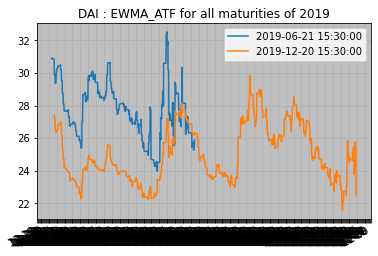

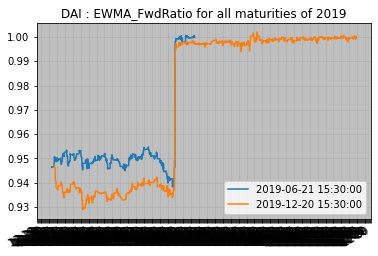

In [12]:
g = Graph('DAI')
g.graph_inputs(year = 2019, expi_month=[6, 12], field='EWMA_ATF')
g.graph_inputs(year = 2019, expi_month=[6, 12], field='EWMA_FwdRatio')

**The final preparation work is to build the Xs and Ys for our Machine Learning process**

**The BuildXY class aims to convert those time series into "stationary" ones**

The idea here is that we are trying to detect a trading pattern that may be common to all instances of asymmetric information. We need to iron out everything that is specific to a certain period or stock, along with false positives, in order to get clean data.
Here are the steps taken :

1/ Look at forward parameters :
This cleans out any punctual event like a dividend ex date that will inevitably prompt a jump in the spot/forward ratio but not in a  "forward - spot/forward ratio" which is computed as the ratio of two spot/forward ratio on different maturities (typically a long term one divided by the nearby).
Similarly, when a company publishes its earnings report, the implicit vol will collapse but the forward vol will be mostly unaffected on average, which is what we want. This is what the differentiate_matu function does.

2/ Short term trend divided by long term trend :
This simply uses exponentially weighted moving average in order to detect short term variation of volume/level from a long term average. This is done by the  differentiate_time function. This is also where the Y series is generated : it simply consist in observing parameters variation over the 5 days following the date at which we oberve the Xs.

3/ For each single stock underlying (here only DAI), we divide its time-series by the corresponding time series of the euro stoxx 50 index :
This will iron out market regimes.

In [13]:
class Data():
    def __init__(self, udl):
        self.udl = udl
        self.df = pd.read_pickle(folder2 + '/Inputs_' + udl + '.pkl')
        # self.timeline = sorted(list(set(self.df.index.tolist())))
        self.list_expi = self.df.MaturityDate.unique()

        self.listdif1 = ['EWMA_ATF', 'EWMA_FwdRatio']
        self.listdif2 = ['TotalSignedSensiATF', 'TotalSignedSensiSMI', 'TotalSignedSensiFwdRatio']
        self.listdif3 = ['EWMA_SMI'] #do nothing
        self.listdif4 = ['TotalSensiATF', 'TotalSensiSMI', 'TotalSensiFwdRatio', 'NumberOfTrades'] #integrate over all matu
        self.listdif5 = ['TradedVolume'] #do nothing

    def find_nearby(self, row):
        res = [np.nan, np.nan, np.nan, np.nan]
        lst = [(time_between(row.name, elt), elt) for elt in self.list_expi if not np.isnan(row[elt])]
        if len(lst) > 0:
            res[0] = lst[0][0]
            res[1] = lst[0][1]
        if (len(lst) > 1) and (lst[1][0] < 60*60*24*30): #dont use as nearby if more than 30days away
            res[2] = lst[1][0]
            res[3] = lst[1][1]
        return res


    def vol_fwd(self, row, f, rank):
        nb = row['nearby_date' + str(rank)]
        if nb in self.list_expi:
            t2 = time_between(row.name, f)
            var2 = t2 * row[f] ** 2
            t1 = row['nearby_TTM' + str(rank)]
            var1 = t1 * row[nb]**2

            if (t1==t2) or (t2/t1-1 < .5) or (var2 < 2*var1):
                #if we can't compute a fwd vol because this is the nearby maturity or
                # or we want the fwd time to be greater than 150% of the time to nearby to avoid levying errors too much
                # or we in a dangerous case of very steep termstructure
                # then we return the vol itself
                return (row[f], 0)
            else:
                return (((var2 - var1) / (t2 - t1)) ** 0.5, 1)
        else:
            return (np.nan, 0)


    def get_ratio(self, row, f, rank):
        nb = row['nearby_date' + str(rank)]
        if nb in self.list_expi:
            if f==row['nearby_date' + str(rank)]:
                return (row[f], 0)
            else:
                return (row[f] / row[row['nearby_date' + str(rank)]], 1)
        else:
            return (np.nan, 0)


    def integrate(self, row, way, matu, stopat = -2):
        if matu in ['nearby_date0', 'nearby_date1']:
            matu = row[matu]
            if pd.isnull(matu):
                return 0
        if matu == 0:
            pos = 0
        else:
            pos = row.index.tolist().index(matu)

        if way == 'from':
            lst = [elt for elt in row[pos:stopat].values if not np.isnan(elt)]  #stop at -2 if the last 2 columns are nearby dates
            return sum(lst)
        else:
            lst = [elt for elt in row[:pos+1].values if not np.isnan(elt)]
            return sum(lst)


    def differentiate_matu(self):
        #!!!! passer en working days

        self.dfmultiindex = self.df[self.listdif1 + self.listdif2 + self.listdif3 + self.listdif4].set_index([self.df.index, self.df.MaturityDate])
        self.df_pivot = self.dfmultiindex.unstack(-1)

        for f in self.listdif1:
            print(f)
            idx = pd.IndexSlice
            self.dft = self.df_pivot.loc[:, idx[f, :]]
            self.list_expi = [elt[1] for elt in self.dft.columns]
            self.dft.columns = self.list_expi
            self.list_expi = sorted(self.list_expi)
            self.dft = self.dft[self.list_expi]

            self.dft[['nearby_TTM0', 'nearby_date0', 'nearby_TTM1', 'nearby_date1']] = \
                self.dft.apply(lambda x: self.find_nearby(x), axis='columns', result_type='expand')

            for rank, lib in [(0, ''), (1, '2nd')]:
                self.df_pivot[('nearby_date' + str(rank), 'allexpi')] = self.dft['nearby_date' + str(rank)]

                for mt in self.list_expi:  #[pd.Timestamp('2019-12-20 15:30:00')]: #self.list_expi:
                    if f == 'EWMA_ATF':
                        df = self.dft.apply(lambda x: self.vol_fwd(x, mt, rank), axis='columns', result_type='expand')
                    if f == 'EWMA_FwdRatio':
                        df = self.dft.apply(lambda x: self.get_ratio(x, mt, rank), axis='columns', result_type='expand')

                    self.df_pivot[(f + lib, mt)] = df[0]
                    self.df_pivot[(f + lib + "-type", mt)] = df[1]

        for f in self.listdif2:
            print(f)

            # We create dft with f-related columns and the nearby dates
            idx = pd.IndexSlice
            self.dft = self.df_pivot.loc[:, idx[f, :]]
            self.dft = pd.concat([self.dft, self.df_pivot.loc[:, [('nearby_date0', 'allexpi'), ('nearby_date1', 'allexpi')]]], axis=1, join="inner")
            #end then rename columns to keep only relevant level
            self.dft.columns = [elt[1] if elt[0][:6] != 'nearby' else elt[0] for elt in self.dft.columns]

            for mt in self.list_expi:
                self.df_pivot[(f + 'nodif', mt)] = self.dft.apply(lambda x: self.integrate(x, 'from', mt), axis='columns')
                self.df_pivot[(f + 'nearby0', mt)] = self.df_pivot[(f + 'nodif', mt)] - self.dft.apply(lambda x: self.integrate(x, 'upto', 'nearby_date0'), axis='columns')
                self.df_pivot[(f + 'nearby1', mt)] = self.df_pivot[(f + 'nodif', mt)] - self.dft.apply(lambda x: self.integrate(x, 'upto', 'nearby_date1'), axis='columns')
                self.df_pivot[(f + 'nearby0-date', mt)] = self.dft['nearby_date0']
                self.df_pivot[(f + 'nearby1-date', mt)] = self.dft['nearby_date1']


        for f in self.listdif3:
            print(f)
            #do nothing


        # self.listdif4
        for f in self.listdif4:
            print(f)
            idx = pd.IndexSlice
            self.dft = self.df_pivot.loc[:, idx[f, :]]
            self.dft.columns = [elt[1] for elt in self.dft.columns]
            self.df_pivot[f, 'allexpi'] = self.dft.apply(lambda x: self.integrate(x, 'from', 0, 1000), axis='columns')


        #self.listdif5
        newname = [(elt, 'allexpi') for elt in self.listdif5]
        self.dft = self.df[self.listdif5]
        self.dft.columns = newname
        self.dft = self.dft[~self.dft.index.duplicated(keep='first')]
        self.df_pivot = pd.concat([self.df_pivot, self.dft], axis=1, join="inner")


    def choose_sensi(self, x, cl, refcl):
        if x[refcl + '-type'] == 0:
            return x['dt-' + cl + 'nodif'], x[cl + 'nodif']
        elif x[refcl + '-nearby'] == x[cl + 'nearby0-date']:
            return x['dt-' + cl + 'nearby0'], x[cl + 'nearby0']
        elif x[refcl + '-nearby'] == x[cl + 'nearby1-date']:
            return x['dt-' + cl + 'nearby0'], x[cl + 'nearby0']
        else:
            return np.nan, np.nan


    def differentiate_time(self, st, lt, Ylag):
        print('differentiate_time')
        st_td = datetime.timedelta(days=st)
        lt_td = datetime.timedelta(days=lt)
        st_min = int(st * 60 * 8.5)
        lt_min = int(lt * 60 * 8.5)
        Ylag_min = int(Ylag * 60 * 8.5)

        # here we need to decide if we want NumberOfTrades summed up or for each matu
        for field in self.listdif4:
            self.df_pivot.drop(
                [elt for elt in self.df_pivot.columns if ((elt[0] == field) and (elt[1] != 'allexpi'))], axis=1, inplace=True)

        self.X = pd.DataFrame()
        for expi in self.list_expi:
            print(expi)

            self.listcol = [elt for elt in self.df_pivot.columns if elt[1] in [expi, 'allexpi']]


            self.dfu = self.df_pivot[self.listcol]
            self.listcol = [elt[0] for elt in self.listcol]
            self.dfu.columns = self.listcol

            self.Xt = pd.DataFrame()

            for cl in self.listdif1:
                print(cl)
                ncol = [cl, cl+'-nearby', cl+'-type']

                self.dftj = pd.DataFrame(columns=ncol)

                dft1 = self.dfu[[cl, 'nearby_date0', cl+'-type']]
                dft1.columns = ncol
                dft2 = self.dfu[[cl + '2nd', 'nearby_date1', cl + '2nd' + '-type']]
                dft2.columns = ncol
                self.dft = dft1.append(dft2)
                self.dft = self.dft.dropna(subset=[cl])

                # if type indicates that no differentiation has been done (type==0) then there is no nearby -> 1st jan 2000
                self.dft[cl+'-nearby'] = self.dft.apply(lambda x: pd.Timestamp('2000-01-01 00:00:00') if x[cl + '-type'] == 0 else x[cl + '-nearby'], axis=1)

                self.list_nearby = [elt for elt in list(set(self.dft[cl+'-nearby'].tolist())) if elt is not None]

                for nb in self.list_nearby:
                    self.dfti = self.dft.loc[self.dft[cl+'-nearby'] == nb]
                    self.dfti = self.dfti.groupby(self.dfti.index).first() #I don't see why there could be more than one line for the same time
                    self.dfti = self.dfti.sort_index()

                    # apply ewma to same nearby matu:
                    dfst = self.dfti[cl].ewm(span=st_min, min_periods=st_min).mean()
                    if st == 0:
                        self.dfti['dt-' + cl] = (self.dfti[cl] / self.dfti[cl].ewm(span=lt_min, min_periods=int(lt_min/2)).mean()) - 1
                    else:
                        self.dfti['dt-' + cl] = dfst / self.dfti[cl].ewm(span=lt_min, min_periods=int(lt_min/2)).mean() - 1


                    # #here we prefer to calculate ewm using the actual date because it is good to create a gap in between days, espacially for diyield when there is an ex-date
                    # dfst = self.dfti[cl].ewm(halflife=st_td, times=self.dfti.index)).mean()
                    # if st==0:
                    #     self.dfti['dt-' + cl] = self.dfti[cl] / self.dfti[cl].ewm(halflife=lt_td, times=self.dfti.index).mean() - 1
                    # else:
                    #     self.dfti['dt-' + cl] = dfst / self.dfti[cl].ewm(halflife=lt_td, times=self.dfti.index).mean() - 1
                    #

                    self.dfti['Y-' + cl] = dfst.shift(-Ylag_min) / dfst - 1

                    #maybe add a protection against holes in the index to make sure shift(-Ylag_min) does take us approx Ylag days ahead
                    self.dfti['timest'] = self.dfti.index
                    self.dfti['validY'] = (self.dfti.shift(-Ylag_min).timest - self.dfti.timest).apply(lambda x : x.total_seconds())/(60*60*24)
                    # print('Before Y verif : ' + str(self.dfti.shape))
                    self.dfti = self.dfti.loc[(self.dfti.validY < Ylag+3)] #2 for a weekend, one for leeway
                    # print('After Y verif : ' + str(self.dfti.shape))
                    del self.dfti['timest']

                    self.dftj = self.dftj.append(self.dfti)

                if self.dftj.shape[0] > 0:
                    # if self.udl!=ref: #we keep everything for the ref to make sure we wont loose lines when we intersect index
                    self.dftj = self.dftj.sort_values(by=cl+'-nearby') #so than when we take first(), the vol.ewm(st)/vol.ewm(lt) calculated with the shortest nearby will be kept
                    self.dftj = self.dftj.groupby(self.dftj.index).first()
                    # NB : it is important to do it only at this stage to make sure that the transition between the
                    # nearby maturities is done smoothly and time differentiation won't mix fwd vols with different nearby maturity
                    self.dftj = self.dftj.sort_index()

                self.Xt = pd.concat([self.Xt, self.dftj[[cl, 'dt-'+cl, cl + '-nearby', 'Y-' + cl, cl+'-type']]], axis=1)

            for cl in self.listdif2:
                print(cl)
                if cl == 'TotalSignedSensiFwdRatio':
                    refcl = 'EWMA_FwdRatio'
                else:
                    refcl = 'EWMA_ATF'

                unsigned_cl = cl.replace("Signed", "")

                self.dft = self.dfu[[refcl, cl + 'nodif', cl + 'nearby0', cl + 'nearby1', cl + 'nearby0-date', cl + 'nearby1-date', unsigned_cl]]
                self.dft = self.dft.dropna(subset=[refcl]) #refcl is only here in order to reduce size

                for f in [cl + 'nodif', cl + 'nearby0', cl + 'nearby1']:

                    if st == 0:
                        self.dft['dt-' + f] = (self.dft[f] / self.dft[f].ewm(span=lt_min, min_periods=int(lt_min/2)).mean())
                    else:
                        self.dft['dt-' + f] = (self.dft[f].ewm(span=st_min, min_periods=st_min).mean() / self.dft[unsigned_cl].ewm(span=lt_min, min_periods=int(lt_min/2)).mean()) #mean is already 0 so no need for a -1

                    #     if st == 0:
                    #         self.dft['dt-' + f] = (self.dft[f] / self.dft[f].ewm(halflife=lt_td, times=self.dfti.index).mean()) - 1
                    #     else:
                    #         self.dft['dt-' + f] = (self.dft[f].ewm(halflife=st_td, times=self.dft.index).mean() / self.dft[f].ewm(halflife=lt_td, times=self.dft.index).mean()) - 1

                self.dft = pd.concat([self.Xt[[refcl+'-nearby', refcl+'-type']], self.dft], axis=1) #add nearby chosen for refcl to pick the one which matches among ['dt-'+cl + 'nodif', 'dt-'+cl + 'nearby0', 'dt-'+cl + 'nearby1'
                self.dft_chosen = self.dft.apply(lambda x: self.choose_sensi(x, cl, refcl), axis='columns', result_type='expand')
                self.dft_chosen.columns = ['dt-' + cl, cl]

                self.Xt = pd.concat([self.Xt, self.dft_chosen], axis=1)

            for cl in self.listdif3 + self.listdif4 + self.listdif5:
                print(cl)

                self.dft = self.dfu[[refcl, cl]] #we include refcl just to reduce size hereafter
                self.dft = self.dft.dropna(subset=[refcl]) #in order to reduce size

                if st == 0:
                    self.dft['dt-' + cl] = (self.dft[cl] / self.dft[cl].ewm(span=lt_min, min_periods=int(lt_min/2)).mean()) - 1
                else:
                    self.dft['dt-' + cl] = (self.dft[cl].ewm(span=st_min, min_periods=st_min).mean() / self.dft[cl].ewm(span=lt_min, min_periods=int(lt_min/2)).mean()) - 1
                # is it better to follow the open time or the real time? when we get 30min interval calibration maybe revert to open time...

                # if st == 0:
                #     self.dft['dt-' + cl] = (self.dft[cl] / self.dft[cl].ewm(halflife=lt_td, times=self.dft.index).mean()) - 1
                # else:
                #     self.dft['dt-' + cl] = (self.dft[cl].ewm(halflife=st_td, times=self.dft.index).mean() / self.dft[cl].ewm(halflife=lt_td, times=self.dft.index).mean()) - 1

                self.Xt = pd.concat([self.Xt, self.dft[['dt-' + cl, cl]]], axis=1)

            self.Xt['Matu'] = expi
            self.X = self.X.append(self.Xt)

        # self.X = self.X.dropna()
        self.X = self.X.set_index([self.X.index, self.X.Matu])
        del self.X['Matu']



    def filter(self, TTM = 1, type = 1):
        #TTM
        self.X['TTM'] = self.X.index.get_level_values(1) - self.X.index.get_level_values(0)
        self.X['TTM'] = self.X['TTM'].apply(lambda x: x.total_seconds() / 60 / 60 / 24 / 365)
        self.X = self.X.loc[self.X.TTM < TTM]
        del self.X['TTM']

        if type == 1:
            for cl in [elt + '-type' for elt in self.listdif1]:
                self.X = self.X.loc[self.X[cl] != 0]
        if type == 2:
            for cl in [elt + '-type' for elt in self.listdif1]:
                self.X = self.X.loc[self.X[cl] != 1]

        rc = [elt for elt in self.X.columns if elt[-5:] != '-type']
        self.X = self.X[rc]


    def difref(self, x, ref):
        if x * ref <= 0:
            return x
        elif abs(ref)>1:
            return x/ref
        else:
            return x


    def differentiate_refindex(self, XRef, exclude):
        value_cols = [elt for elt in self.X.columns if elt != 'udl']
        for takeout in exclude + ['nearby']:
            value_cols = [elt for elt in value_cols if (takeout not in elt)]

        idx = np.intersect1d(self.X.index, XRef.index)
        self.X = self.X.loc[idx]
        XRef = XRef.loc[idx]
        vecF = np.vectorize(self.difref)
        dfe = pd.DataFrame(vecF(self.X[value_cols], XRef[value_cols]))
        dfe.index = idx
        dfe.columns = value_cols
        self.X[value_cols] = dfe


    def Cat_Y(self, y, threshold):
        if y>=threshold:
            return(1)
        elif y<=-1*threshold:
            return(-1)
        else:
            return(0)


    def normalize(self, cap):
        value_cols = [elt for elt in self.X.columns if 'nearby' not in elt]
        self.X[value_cols] = self.X[value_cols] - self.X[value_cols].mean()
        self.X[value_cols] = self.X[value_cols] / self.X[value_cols].std()
        for f in value_cols:
            self.X[f] = self.X[f].apply(lambda x: np.nan if np. isnan(x) else min(cap, max(x, -1*cap)))

        Y_cols = [elt for elt in value_cols if elt[:2] == 'Y-']
        for f in Y_cols:
            self.X[f] = self.X[f].apply(lambda x: self.Cat_Y(x, cap))


**And now we use this class on DAI and SX5E**

In [14]:
# Step 1 : Look at forward parameters
for udl in stocks_list:
    print(udl)
    data = Data(udl)
    data.differentiate_matu()
    data.df_pivot.to_pickle(folder3 + '/X_' + udl + '.pkl')

SX5E
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwdRatio
NumberOfTrades
DAI
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwdRatio
NumberOfTrades


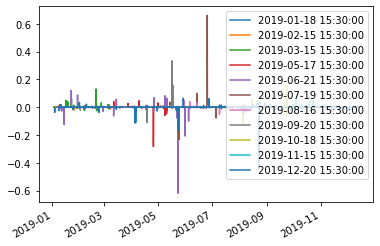

In [15]:
#Here is a representation of the vector obtained
g = Graph('DAI')
g.graph_X(year=2019, field='TotalSignedSensiATF')


In [16]:
# Step 2 : Short term trend divided by long term trend + computing the Y vector

st = 2 #in days
lt = 20 #in days
Ylag = 5 #in days

for udl in stocks_list:
    print(udl)
    data = Data(udl)
    data.df_pivot = pd.read_pickle(folder3 + '/X_' + udl + '.pkl')
    data.differentiate_time(st, lt, Ylag)  #...and compute Y
    data.X.to_pickle(folder3 + '/Xtd_' + udl + '.pkl')

    print(data.X.head(5))

SX5E
differentiate_time
2019-01-18T15:30:00.000000000
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwdRatio
NumberOfTrades
TradedVolume
2019-02-15T15:30:00.000000000
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwdRatio
NumberOfTrades
TradedVolume
2019-03-15T15:30:00.000000000
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwdRatio
NumberOfTrades
TradedVolume
2019-05-17T15:30:00.000000000
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwdRatio
NumberOfTrades
TradedVolume
2019-06-21T15:30:00.000000000
EWMA_ATF
EWMA_FwdRatio
TotalSignedSensiATF
TotalSignedSensiSMI
TotalSignedSensiFwdRatio
EWMA_SMI
TotalSensiATF
TotalSensiSMI
TotalSensiFwd

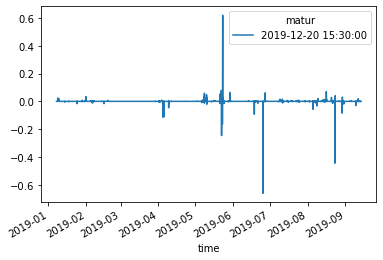

In [17]:
#Here is a representation of the vector obtained (2)
g = Graph('DAI')
g.graph_XY(year=2019, month=12, field='TotalSignedSensiATF', filtertype = 1, stage='xdt')

In [18]:
# Step 3 : we divide by the ref index (SX5E), apply cap-floor, and change Ys into groups as we plan to use a clustering Machine Learning (ML) algo
filter_type = 1
cap = 2

for udl in stocks_list:
    data = Data(udl)

    data.X = pd.read_pickle(folder3 + '/Xtd_' + udl + '.pkl')

    print('filter')
    data.filter(TTM=1, type=filter_type)  #TTM in years;  type in 1:fwd only, 2:nearby only, 3: both

    if udl not in [ref]:
        XRef = pd.read_pickle(folder3 + '/XY_' + ref + '.pkl')

        data.differentiate_refindex(XRef, exclude=['FwdRatio', 'TotalSignedSensi'])

        data.normalize(cap)
        #is it better to normalize before or after joining the underlyings? Both have pros and cons.

        data.X.to_pickle(folder3 + '/XY_' + udl + '.pkl')
    else:
        data.X.to_pickle(folder3 + '/XY_' + udl + '.pkl')



filter
filter


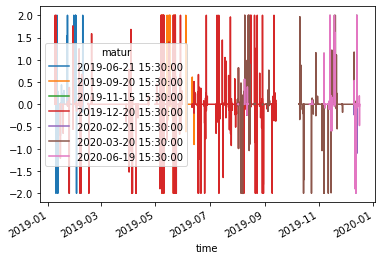

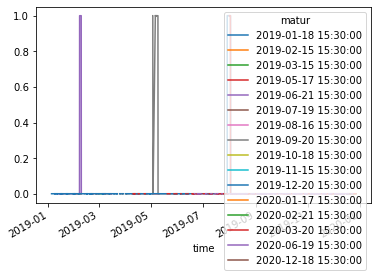

In [19]:
#Here is a representation of the vector obtained
g = Graph('DAI')
g.graph_XY(year='', field='TotalSignedSensiATF', stage='xy')
g.graph_XY(year='', field='Y-EWMA_ATF', stage='xy')


In [20]:
#We finally merge all the dataframe for all single stocks (here only DAI)

df = pd.DataFrame()
for udl in [elt for elt in stocks_list if elt not in indexlist]:
    dft = pd.read_pickle(folder3 + '/XY_' + udl + '.pkl')
    dft['udl'] = udl
    df = df.append(dft)
df.to_pickle(folder3 + '/XY_all_stocks -st_' + str(st) + '-lt_' + str(lt) + '-type_' + str(filter_type) + '-cap_' + str(cap) + '.pkl')

**The following graphical representation of the vectors obtained is not encouraging**

In black are the points where Y is at +2std dev, in red those with Y at -2std.

It shows that the only X vector which can be used to discriminate between cases when the parameter will move suddenly in the future (black points) and benign situations.
This means that "the market will move suddenly in the near future if it has sharply moved recently".

The TotalSignedSensiATF parameter doesn't seem to discriminate much (Y axis)

My interpretation is that our way of "signing" the trades is not satisfactory and would require the use of bid offer data which are not available for free.

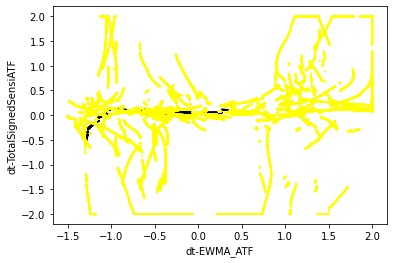

average distance to center y=0 vs y=1 : dt-EWMA_ATF, dt-TotalSignedSensiATF, Y-EWMA_ATF
average distance to center y=0 vs y=1 : dt-EWMA_FwdRatio, dt-TotalSensiFwdRatio, Y-EWMA_FwdRatio


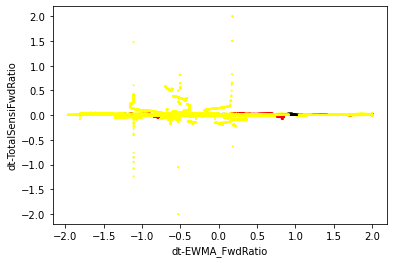

In [21]:
#Here is the result :
g = Graph('DAI')
g.graph_XY_scatter('dt-EWMA_ATF', 'dt-TotalSignedSensiATF', 'Y-EWMA_ATF')
g.graph_XY_scatter('dt-EWMA_FwdRatio', 'dt-TotalSensiFwdRatio', 'Y-EWMA_FwdRatio')

**Nevertheless, we will try to run a quick ML in order to alert to a possible asymmetric information situation**

Cases of sudden move of a parameter (here 2 standard deviations) are rare and only a fraction of those events would have been preceded by abnormal trading patterns due to well informed agents trying to take advantage.
As a consequence, there is not enough data to feed a complex Neural Network.
If we were to use a complex NN, we would probably run into over-parameterization issues.

In [22]:
f = pd.read_pickle(folder3 + '/XY_all_stocks -st_' + str(st) + '-lt_' + str(lt) + '-type_' + str(filter_type) + '-cap_' + str(cap) + '.pkl')
Xcol = ['dt-EWMA_ATF', 'dt-TotalSensiATF', 'dt-NumberOfTrades']
df['RY'] = 1 - df['Y-EWMA_ATF']
Ycol = ['Y-EWMA_ATF', 'RY']
df = df.dropna(subset=Xcol + Ycol, how='any')
X = df[Xcol].values.astype(float)
y = df[Ycol].values.astype(float)
sep = int(X.shape[0]/2)
X_train = X[:sep]
y_train = y[:sep]
X_test = X[sep:]
y_test = y[sep:]

model = Sequential()
model.add(Dense(4, activation='relu', input_dim=3))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=1)

pred_train = model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_test = model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))




1486/1486 [==============================] - 1s 549us/step - loss: 0.3003 - accuracy: 0.8880